# Build predictive model using Facebook Prophet

### Install Prophet and its dependencies

In [1]:
# !pip3 install pystan
# !pip3 install fbprophet

In [2]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [3]:
# Utilities functions created in previous notebooks 
import pandas as pd
import os
import numpy as np

def load_dataset(subfolder='', file='aapl.us.txt', data_type='raw', index_column=0):
    data_path = os.path.join(os.path.pardir, 'data', data_type, subfolder, file)
    print('Opening file ', data_path)
    df = pd.read_csv(data_path, index_col=index_column)
    print('%d missing values found' % df.isnull().sum().sum())
    return df


### Prophet utilities

In [40]:


def prepare_prophet_dataset (file = 'dataset_feature_vector.csv', data_type = 'processed', initial_date = '2005-01-01', cap = '', floor = ''):
    dataset = load_dataset('',file, data_type)
    prophet_df = pd.DataFrame()
    prophet_df['ds'] = pd.to_datetime(dataset['Date'])
    prophet_df['y'] = dataset['Open']
    # As the Open price curve is pretty still during the first years of Apple lets 
    # analyze from the moment it gets intresting 
    df = prophet_df[prophet_df.ds > pd.to_datetime(initial_date)].copy()
    if(cap != '' and floor != ''):
        df['cap'] = cap
        df['floor'] = floor
        
    print('Complete dataset size {0}'.format(df.shape))
    return df


def plot_prophet_curves(model, forecast):
    ax_config={
        'y':{'formatter':'$%1.2f',
            'major_locator':10,
            'minor_locator':5,
            'label':'Stock price',
            'lim_inf':0,
            'lim_sup':180},
        'x':{'minor_locator':365}
    }
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True, sharex=True, facecolor='w', edgecolor='k', dpi=80)
    [(lambda x: _axes_configuration(x, ax_config)) for x in axs]
    model.plot(forecast, ax = axs[0])
    a = add_changepoints_to_plot(axs[1], model, forecast)
    plt.show()
    fig = plot_plotly(model, forecast)  # This returns a plotly Figure
    py.iplot(fig)  
#     fig2 = prophet_linear.plot_components(forecast)
#     plt.show()


def _axes_configuration(ax,config):
    ax.yaxis.set_major_formatter(FormatStrFormatter(config['y']['formatter']))
    ax.yaxis.set_major_locator(MultipleLocator(config['y']['major_locator']))
    ax.yaxis.set_minor_locator(MultipleLocator(config['y']['minor_locator']))
    ax.set_ylabel(config['y']['label'])
    ax.set_ylim(config['y']['lim_inf'],config['y']['lim_sup']) 
    ax.xaxis.set_minor_locator(MultipleLocator(config['x']['minor_locator']))
    ax.set_xlim('01-01-2005','01-01-2019')
    

def plot_prophet_cross_validation_results(model, df_cv,initial='2005-01-01', cutoffStr='2014-11-20'):
    cutoff = df_cv['cutoff'].unique()[0]
    fig = plt.figure(facecolor='w', figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(model.history['ds'].values, model.history['y'], 'k.')
    ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
    ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
    ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
    ax.set_ylabel('Forcast price')
    ax.set_xlabel('Time')
    ax.text(x=pd.to_datetime(initial),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
    ax.text(x=pd.to_datetime(cutoffStr),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
    ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
       alpha=0.5, ls='--')
    ax.text(x=pd.to_datetime('2016-11-19'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);



# def get_dataset_partitions(file='dataset_feature_vector.csv', data_type='processed', initial_date='2005-01-01', partition_date='2015-01-01')
#     df = prepare_prophet_dataset(file, data_type, initial_date)
#     train = prophet_df[(prophet_df.ds < pd.to_datetime(partition_date)) ]
# prophet_test = prophet_df[prophet_df.ds > pd.to_datetime('2015-01-01')]
# import pandas as pd
# import sklearn
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
# from sklearn.utils.multiclass import unique_labels        
# print(prophet_train.shape)
# print(prophet_test.shape)


In [41]:
df = prepare_prophet_dataset ('dataset_feature_vector.csv', 'processed', '2005-01-01')

Opening file  ../data/processed/dataset_feature_vector.csv
0 missing values found
Complete dataset size (3238, 2)


## Before modeling and predicting let's have a clear look of the curve that we want to model/predict

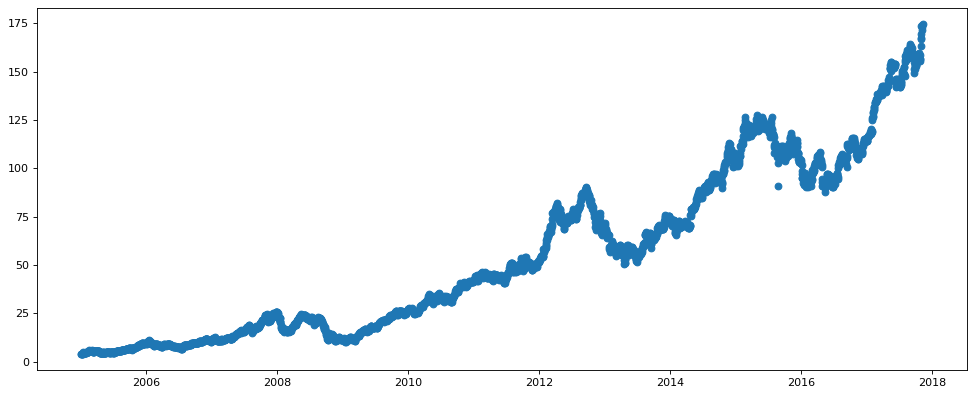

In [42]:
fig = figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(x=df.ds, y=df.y)

In [69]:
prophet = Prophet()
prophet.fit(df)
future = prophet.make_future_dataframe(periods=360, freq='d')
forecast = prophet.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


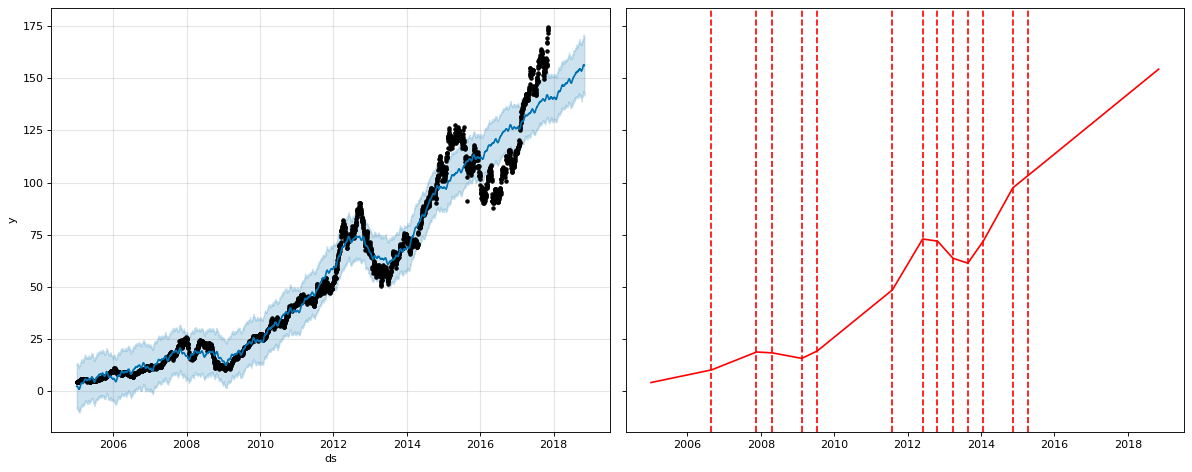

In [70]:
plot_prophet_curves(prophet, forecast)

### We can see that the trend is predicted but the entire algorithmas a predictor is not strong enought without tunning the hyper-parameters

In [71]:
cap = 200
floor = df.y.min()
df_linear = prepare_prophet_dataset ('dataset_feature_vector.csv', 'processed', '2005-01-01', cap, floor)    

Opening file  ../data/processed/dataset_feature_vector.csv
0 missing values found
Complete dataset size (3238, 4)


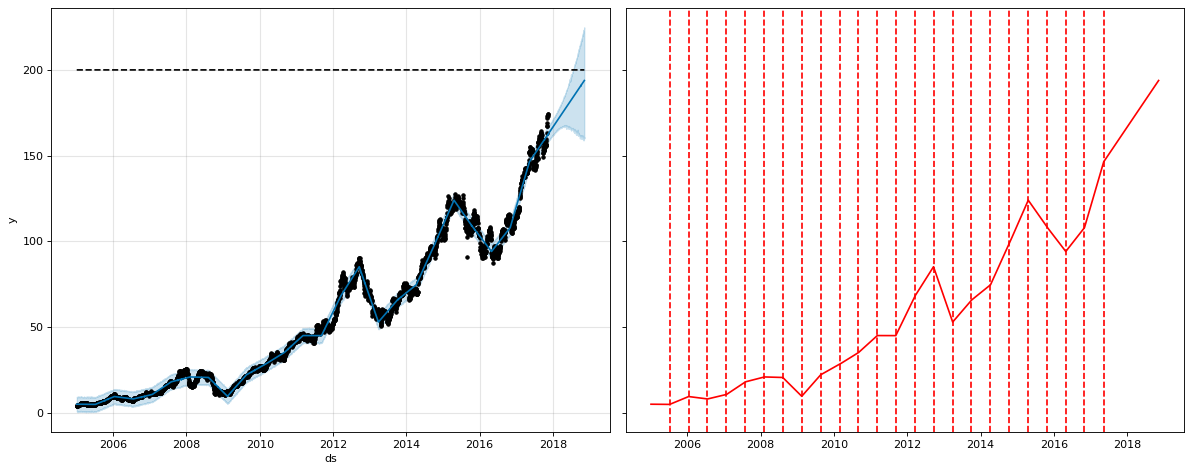

In [72]:

prophet_linear = Prophet(growth='linear',
                  changepoint_range=1,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_prior_scale=20,
                  changepoint_prior_scale=20)
prophet_linear.add_country_holidays(country_name='US')
prophet_linear.fit(df_linear)

future = prophet_linear.make_future_dataframe(periods=365, freq='d')
future['cap'] = cap
future['floor'] = floor

forecast = prophet_linear.predict(future)
plot_prophet_curves(prophet_linear, forecast)

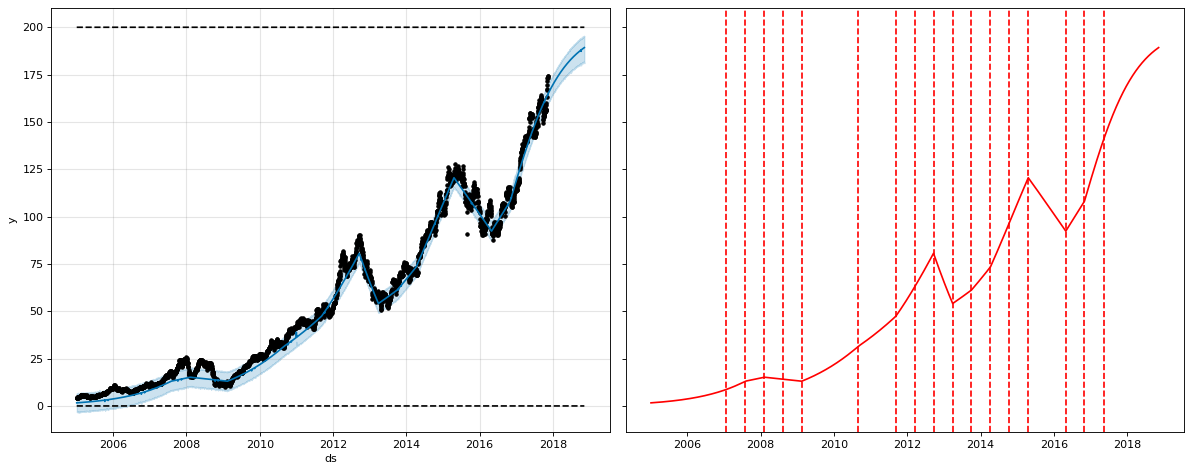

In [73]:
cap = 200
floor = 0
df_logistic = df_linear.copy()
prophet_logistic = Prophet(growth='logistic',
                  changepoint_range=1,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  changepoint_prior_scale=.1,
                  seasonality_mode='additive',
                  seasonality_prior_scale=20,
                  holidays_prior_scale=20,
                  mcmc_samples=0)
prophet_logistic.add_country_holidays(country_name='US')
prophet_logistic.fit(df_logistic)

future = prophet_logistic.make_future_dataframe(periods=365, freq='d')
future['cap'] = cap
future['floor'] = floor

forecast = prophet_logistic.predict(future)
plot_prophet_curves(prophet_logistic, forecast)

# Comparing metrics

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-11-09 00:00:00 and 2016-11-09 00:00:00


['2016-11-09T00:00:00.000000000']


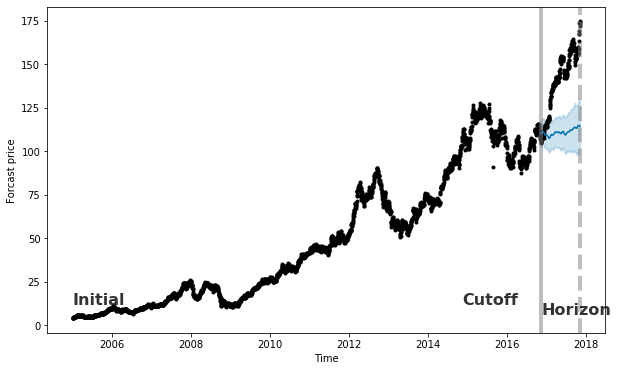

In [78]:
df_cv_simple = cross_validation(
    prophet, initial='4000 days', period='720 days',horizon = '365 days')
cutoff = df_cv_simple['cutoff'].unique()[0]
print(df_cv_simple['cutoff'].unique())
df_cv_simple = df_cv_simple[df_cv_simple['cutoff'].values == cutoff]
simple_performance = performance_metrics(df_cv_simple)
plot_prophet_cross_validation_results(prophet, df_cv_simple,'2005-01-01')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-11-09 00:00:00 and 2016-11-09 00:00:00


['2016-11-09T00:00:00.000000000']


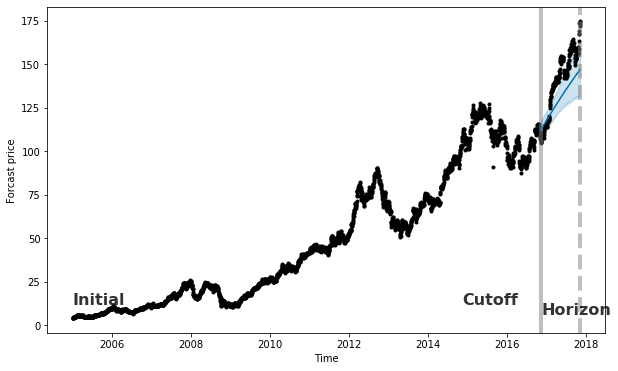

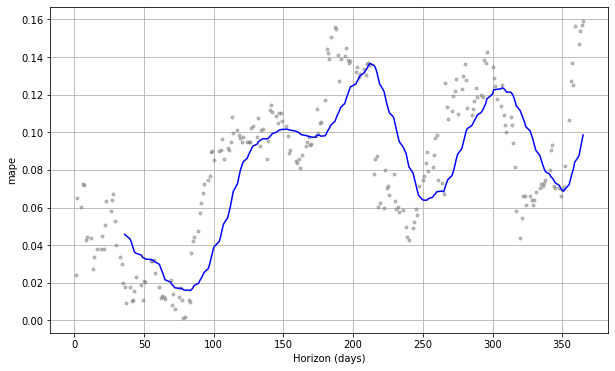

In [79]:
df_cv_logistic = cross_validation(
    prophet_logistic, initial='4000 days', period='720 days',horizon = '365 days')
cutoff = df_cv_logistic['cutoff'].unique()[0]
print(df_cv_logistic['cutoff'].unique())
df_cv_logistic = df_cv_logistic[df_cv_logistic['cutoff'].values == cutoff]
logistic_performance = performance_metrics(df_cv_logistic)
plot_prophet_cross_validation_results(prophet_logistic, df_cv_logistic,'2005-01-01')
fig = plot_cross_validation_metric(df_cv_logistic, metric='mape')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2016-11-09 00:00:00 and 2016-11-09 00:00:00


['2016-11-09T00:00:00.000000000']


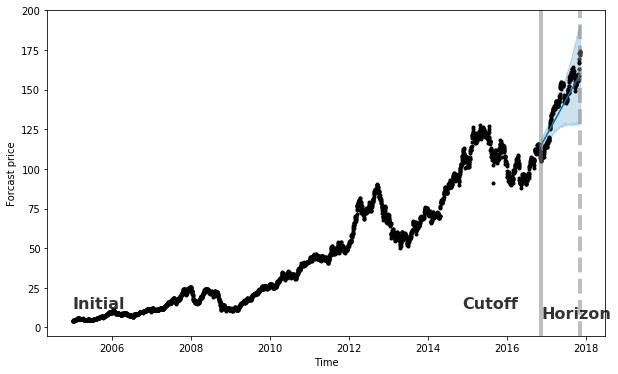

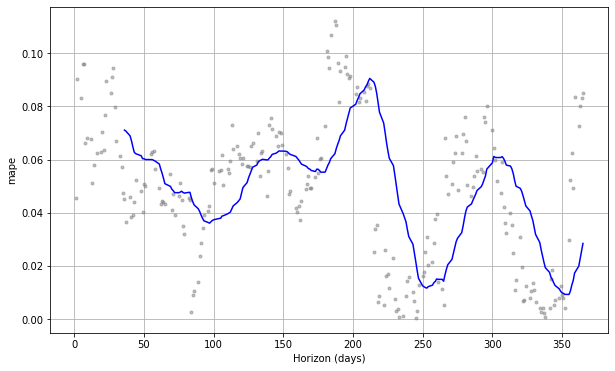

In [80]:
df_cv_linear = cross_validation(
    prophet_linear, initial='4000 days', period='720 days',horizon = '365 days')

cutoff = df_cv_linear['cutoff'].unique()[0]
print(df_cv_linear['cutoff'].unique())
df_cv_linear = df_cv_linear[df_cv_linear['cutoff'].values == cutoff]
linear_performance = performance_metrics(df_cv_linear)
plot_prophet_cross_validation_results(prophet_linear, df_cv_linear,'2005-01-01')
fig = plot_cross_validation_metric(df_cv_linear, metric='mape')

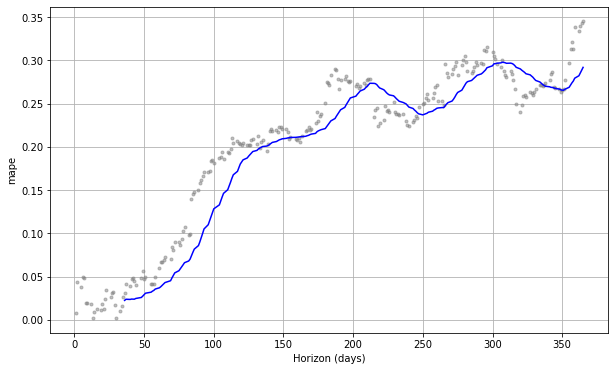

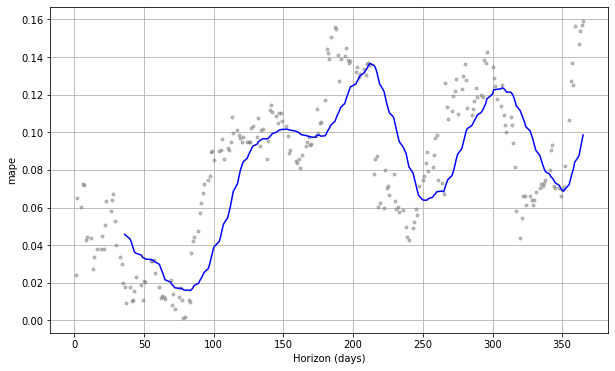

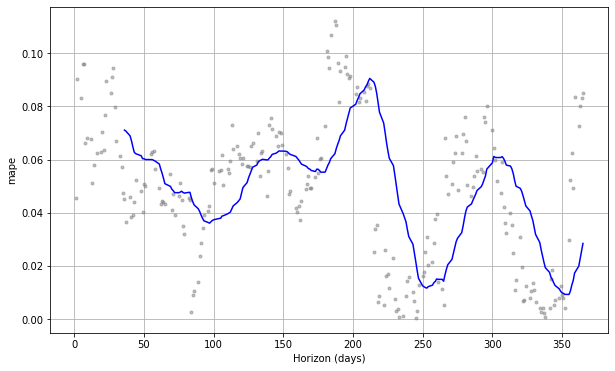

In [81]:
fig = plot_cross_validation_metric(df_cv_simple, metric='mape')
fig = plot_cross_validation_metric(df_cv_logistic, metric='mape')
fig = plot_cross_validation_metric(df_cv_linear, metric='mape')
